In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sorted-comments/comments_cleaned_sorted.xlsx


In [2]:
import pandas as pd
df = pd.read_excel('/kaggle/input/sorted-comments/comments_cleaned_sorted.xlsx')

In [3]:
df.head(5)

,Sr. No.,Category,Project Name,cleaned comments
0,1,Design,NOVAZ Crystal Glass,"I just want to say these are GORGEOUS, and I'm..."
1,1,Design,NOVAZ Crystal Glass,NOVAZCreator
2,1,Design,NOVAZ Crystal Glass,"Hi Michelle, Thanks for your interest in NOVA..."
3,1,Design,NOVAZ Crystal Glass,GuanSuperbacker
4,1,Design,NOVAZ Crystal Glass,Novaz said they are a winner of the Red Dot Aw...


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline, RobertaTokenizer
import traceback

2024-06-03 01:01:22.623335: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 01:01:22.623429: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 01:01:22.845966: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# Set the maximum token length for RoBERTa (512 tokens)
max_token_length = 512

# Load pre-trained RoBERTa sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")
tokenizer = RobertaTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [6]:
# Function to split long text into manageable chunks
def split_long_text(text, max_length):
    words = text.split()
    chunks = []
    current_chunk = []
    current_length = 0

    for word in words:
        word_tokens = tokenizer.encode(word, add_special_tokens=False)
        word_length = len(word_tokens)

        if current_length + word_length > max_length:
            if current_chunk:
                chunks.append(" ".join(current_chunk))
            current_chunk = []
            current_length = 0

        current_chunk.append(word)
        current_length += word_length

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return chunks

# Create an empty DataFrame to store sentiment results
sentiment_results_df = pd.DataFrame(columns=["Project", "Chunk", "Label", "Score"])

# Iterate over each project
project_names = df["Project Name"].unique()
project_index = 0

while project_index < len(project_names):
    project_name = project_names[project_index]
    
    try:
        # Filter comments for the current project
        filtered_df = df[df["Project Name"] == project_name]
        all_comments = " ".join(filtered_df["cleaned comments"])

        if not all_comments.strip():
            print(f"No comments for {project_name}. Skipping.")
            project_index += 1
            continue

        # Split long text into manageable chunks
        chunks = split_long_text(all_comments, max_token_length)

        # Analyze sentiment for each chunk
        sentiment_results_list = []

        for chunk_idx, chunk in enumerate(chunks):
            sentiment_result = sentiment_pipeline(chunk)[0]

            # Store sentiment analysis results in the DataFrame
            sentiment_results_list.append({
                "Project": project_name,
                "Chunk": chunk_idx + 1,
                "Label": sentiment_result["label"],
                "Score": sentiment_result["score"]
            })

        # Concatenate the results to the main DataFrame
        sentiment_results_df = pd.concat([sentiment_results_df, pd.DataFrame(sentiment_results_list)], ignore_index=True)

    except Exception as e:
        # If an error occurs, print the error message and continue
        print(f"Error processing {project_name}: {e}")
        traceback.print_exc()

    project_index += 1


/tmp/ipykernel_34/160024073.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sentiment_results_df = pd.concat([sentiment_results_df, pd.DataFrame(sentiment_results_list)], ignore_index=True)


Error processing ChessUp 2 | Chess.com on a Real Board: sequence item 4: expected str instance, float found


Traceback (most recent call last):
  File "/tmp/ipykernel_34/160024073.py", line 39, in <module>
    all_comments = " ".join(filtered_df["cleaned comments"])
TypeError: sequence item 4: expected str instance, float found


Error processing UGREEN NASync Series: Your Private Cloud Storage Solution.: sequence item 579: expected str instance, float found


Traceback (most recent call last):
  File "/tmp/ipykernel_34/160024073.py", line 39, in <module>
    all_comments = " ".join(filtered_df["cleaned comments"])
TypeError: sequence item 579: expected str instance, float found


Error processing Lofree EDGE, Smoothest Ultra Low-Profile Mechanical Keyboard: sequence item 319: expected str instance, float found


Traceback (most recent call last):
  File "/tmp/ipykernel_34/160024073.py", line 39, in <module>
    all_comments = " ".join(filtered_df["cleaned comments"])
TypeError: sequence item 319: expected str instance, float found


In [7]:
sentiment_results_df

,Project,Chunk,Label,Score
0,NOVAZ Crystal Glass,1,LABEL_2,0.967858
1,NOVAZ Crystal Glass,2,LABEL_2,0.877496
2,"Kibu: Children's Headphones you can Build, Rep...",1,LABEL_2,0.761821
3,"Kibu: Children's Headphones you can Build, Rep...",2,LABEL_1,0.479075
4,"Kibu: Children's Headphones you can Build, Rep...",3,LABEL_2,0.769859
...,...,...,...,...
1116,PhoneMicro5-Portable Smartphone HD Microscope,2,LABEL_1,0.504892
1117,Nomi Brew Podbuster: Bean to cup without the pod.,1,LABEL_2,0.538625
1118,Friend: Open Source AI Wearable Recording Device,1,LABEL_2,0.728553
1119,Friend: Open Source AI Wearable Recording Device,2,LABEL_1,0.923292


In [10]:


# Calculate the average sentiment score for each project
average_sentiment_scores = sentiment_results_df.groupby('Project')['Score'].mean().reset_index()
average_sentiment_scores.columns = ['Project Name', 'Average Sentiment Score']

# Identify the top 3 projects with the highest average sentiment scores
top_3_score_projects = average_sentiment_scores.nlargest(3, 'Average Sentiment Score')
print(top_3_score_projects)


                                         Project Name  Average Sentiment Score
88  Thrown into a Deathmatch with a Final Boss! Li...                 0.993171
61                                   OPAL - Organizer                 0.993159
72                                 SCRD Tactical Gear                 0.993159


In [12]:
# Calculate the average sentiment score for each project
average_sentiment_scores = sentiment_results_df.groupby('Project')['Score'].mean().reset_index()
average_sentiment_scores.columns = ['Project Name', 'Average Sentiment Score']

# Display the complete average sentiment scores for all projects
print("Average Sentiment Scores for All Projects:")
print(average_sentiment_scores)

Average Sentiment Scores for All Projects:
                                         Project Name  Average Sentiment Score
0                                       24:07 watches                 0.682428
1                Adventure Time: The Roleplaying Game                 0.719709
2   American Yakuza - NSFW Murder Mystery Adventur...                 0.558662
3   BANG!CASE | The First Phone Case with 3 Custom...                 0.774436
4   Beyond Limits: Introducing The Next Generation...                 0.646799
..                                                ...                      ...
92                           Wonders of The First CCG                 0.614663
93  Worlds at a Glance: 5E tools to describe towns...                 0.821110
94                  Xeric Invertor II Automatic Watch                 0.626605
95  a "game-changing" business suit for the stylis...                 0.453453
96                               ♠ Ace & ★ Starlet #3                 0.940453

[97 rows

In [19]:
sentiment_results_df

,Project,Chunk,Label,Score
0,NOVAZ Crystal Glass,1,LABEL_2,0.967858
1,NOVAZ Crystal Glass,2,LABEL_2,0.877496
2,"Kibu: Children's Headphones you can Build, Rep...",1,LABEL_2,0.761821
3,"Kibu: Children's Headphones you can Build, Rep...",2,LABEL_1,0.479075
4,"Kibu: Children's Headphones you can Build, Rep...",3,LABEL_2,0.769859
...,...,...,...,...
1116,PhoneMicro5-Portable Smartphone HD Microscope,2,LABEL_1,0.504892
1117,Nomi Brew Podbuster: Bean to cup without the pod.,1,LABEL_2,0.538625
1118,Friend: Open Source AI Wearable Recording Device,1,LABEL_2,0.728553
1119,Friend: Open Source AI Wearable Recording Device,2,LABEL_1,0.923292


In [20]:
# Export the sentiment results to a CSV file
sentiment_results_df.to_csv('sentiment_result.csv', index=False)

In [14]:
# Export the average sentiment scores to a CSV file
average_sentiment_scores.to_csv('average_sentiment_scores.csv', index=False)

In [21]:
import pandas as pd

# Load the sentiment result Excel file
sentiment_results_df = pd.read_csv('/kaggle/input/sentiment-result/sentiment_result.csv')

# Calculate the average sentiment score for each project
average_sentiment_scores = sentiment_results_df.groupby('Project')['Score'].mean().reset_index()
average_sentiment_scores.columns = ['Project Name', 'Average Sentiment Score']

# Sort the average sentiment scores in descending order
sorted_average_sentiment_scores = average_sentiment_scores.sort_values(by='Average Sentiment Score', ascending=False)

# Export the sorted average sentiment scores to a csv file
sorted_average_sentiment_scores.to_csv('sorted_average_sentiment_scores.csv', index=False)

# Display the sorted average sentiment scores
print(sorted_average_sentiment_scores)


                                         Project Name  Average Sentiment Score
88  Thrown into a Deathmatch with a Final Boss! Li...                 0.993171
61                                   OPAL - Organizer                 0.993159
72                                 SCRD Tactical Gear                 0.993159
50                       Lad: The Homecoming Issue #4                 0.989829
63                                      Outbreak Park                 0.988053
..                                                ...                      ...
64  PASSPORT SHELL 2.0 - The Perfect Travel Wallet...                 0.554207
20     Duo Cover 2.0 | The Ultimate Microwave Upgrade                 0.547871
60  Nomi Brew Podbuster: Bean to cup without the pod.                 0.538625
95  a "game-changing" business suit for the stylis...                 0.453453
73  SINOBIS - New Sneaker-Like Dress Shoes for All...                 0.427378

[97 rows x 2 columns]


Most Positive Comments:
                                              Project  Positive Count  \
12                                 Corps of Discovery            81.0   
0                Adventure Time: The Roleplaying Game            59.0   
25                   FREE STARS: Children of Infinity            45.0   
20                         Earth: Abundance Expansion            43.0   
23  Excope DT1|The World's Lightest Super Telephot...            42.0   
22                                Euthia: Cruel Frost            34.0   
65  Runa - turn-based fantasy game inspired by JRP...            29.0   
44                                    Kinfire Council            26.0   
17    Dnsys X1 Exoskeleton: Unleash Superhuman Powers            22.0   
9      Carvera Air: A Smart and Versatile Desktop CNC            19.0   

    Negative Count  
12             2.0  
0              2.0  
25             0.0  
20             8.0  
23             0.0  
22             4.0  
65             0.0  
44  

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20008 (\N{CJK UNIFIED IDEOGRAPH-4E28}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


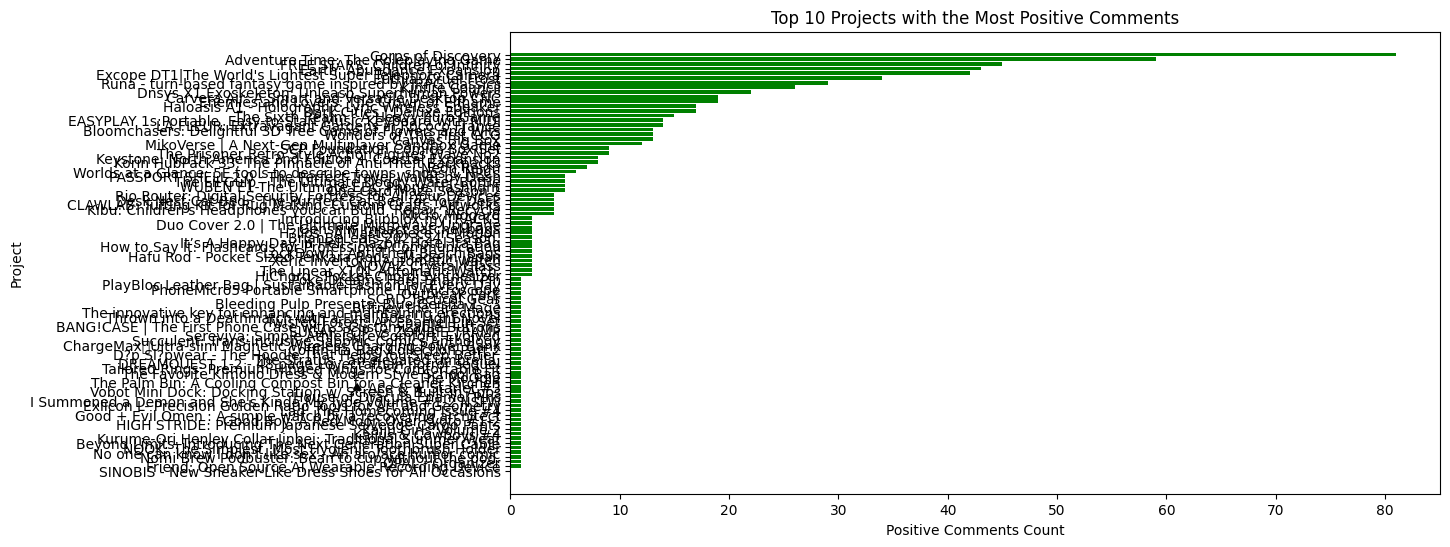

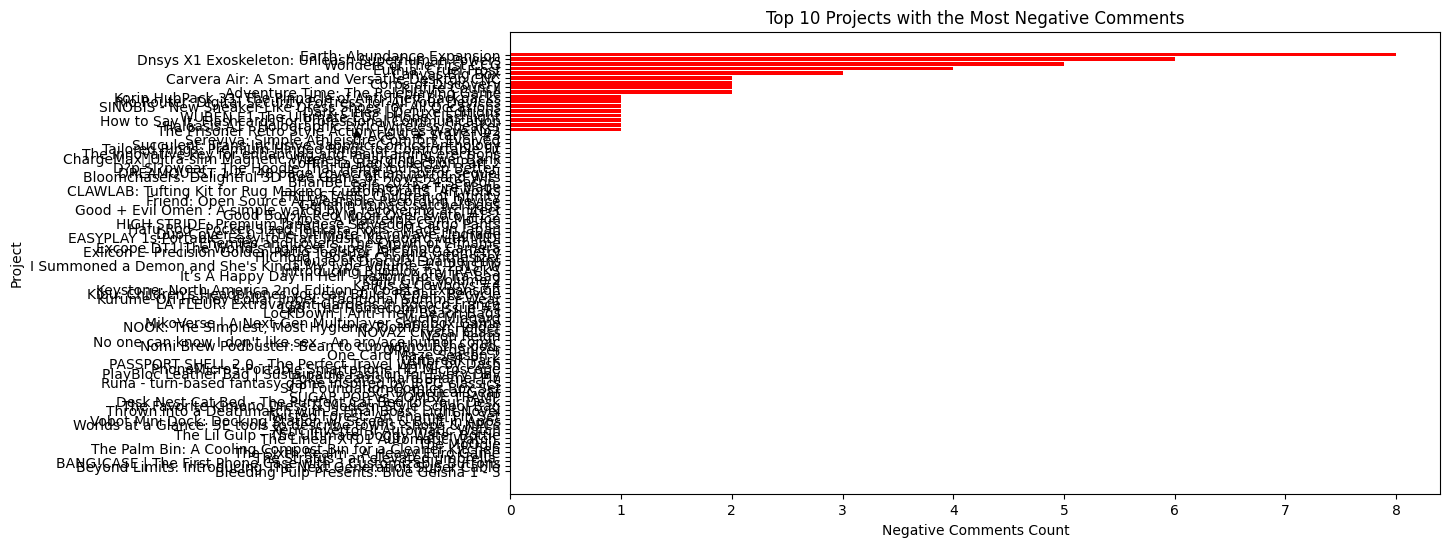

In [24]:
import pandas as pd

# Load the sentiment result Excel file
sentiment_results_df = pd.read_csv('/kaggle/input/sentiment-result/sentiment_result.csv')

# Calculate the count of positive and negative comments for each project
positive_comments = sentiment_results_df[sentiment_results_df['Label'] == 'LABEL_2'].groupby('Project').size().reset_index(name='Positive Count')
negative_comments = sentiment_results_df[sentiment_results_df['Label'] == 'LABEL_0'].groupby('Project').size().reset_index(name='Negative Count')

# Merge positive and negative comments count
comment_counts = pd.merge(positive_comments, negative_comments, on='Project', how='outer').fillna(0)

# Sort projects by most positive comments
most_positive_projects = comment_counts.sort_values(by='Positive Count', ascending=False)

# Sort projects by most negative comments
most_negative_projects = comment_counts.sort_values(by='Negative Count', ascending=False)


# Display the tables
print("Most Positive Comments:")
print(most_positive_projects.head(10))  # Display top 10 for brevity

print("Most Negative Comments:")
print(most_negative_projects.head(10))  # Display top 10 for brevity

# Plot the top 10 projects with the most positive comments
plt.figure(figsize=(12, 6))
plt.barh(most_positive_projects['Project'], most_positive_projects['Positive Count'], color='green')
plt.xlabel('Positive Comments Count')
plt.ylabel('Project')
plt.title('Top 10 Projects with the Most Positive Comments')
plt.gca().invert_yaxis()
plt.show()

# Plot the top 10 projects with the most negative comments
plt.figure(figsize=(12, 6))
plt.barh(most_negative_projects['Project'], most_negative_projects['Negative Count'], color='red')
plt.xlabel('Negative Comments Count')
plt.ylabel('Project')
plt.title('Top 10 Projects with the Most Negative Comments')
plt.gca().invert_yaxis()
plt.show()

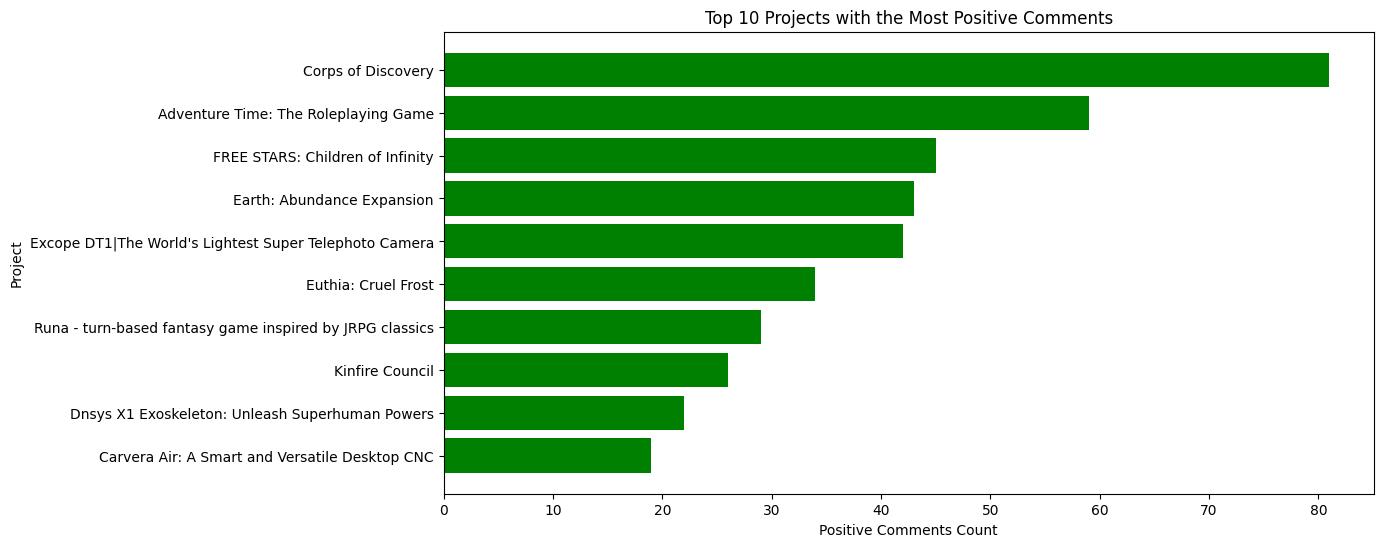

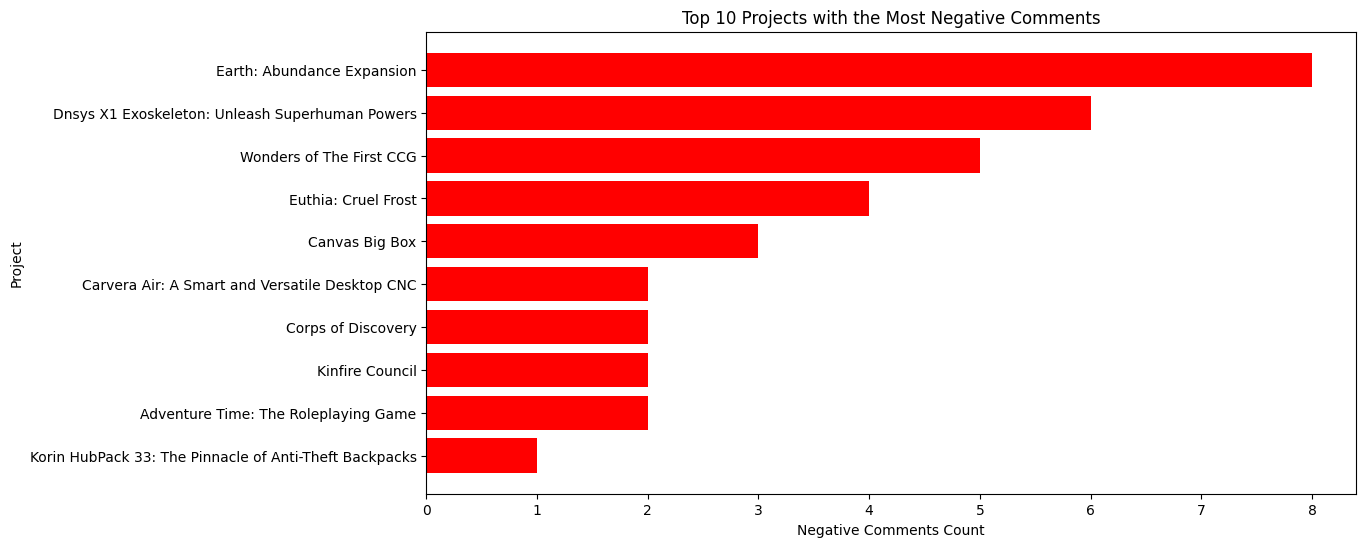

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the sentiment result Excel file
sentiment_results_df = pd.read_csv('/kaggle/input/sentiment-result/sentiment_result.csv')

# Calculate the count of positive and negative comments for each project
positive_comments = sentiment_results_df[sentiment_results_df['Label'] == 'LABEL_2'].groupby('Project').size().reset_index(name='Positive Count')
negative_comments = sentiment_results_df[sentiment_results_df['Label'] == 'LABEL_0'].groupby('Project').size().reset_index(name='Negative Count')

# Merge positive and negative comments count
comment_counts = pd.merge(positive_comments, negative_comments, on='Project', how='outer').fillna(0)

# Sort projects by most positive and negative comments
most_positive_projects = comment_counts.sort_values(by='Positive Count', ascending=False).head(10)
most_negative_projects = comment_counts.sort_values(by='Negative Count', ascending=False).head(10)

# Plot the top 10 projects with the most positive comments
plt.figure(figsize=(12, 6))
plt.barh(most_positive_projects['Project'], most_positive_projects['Positive Count'], color='green')
plt.xlabel('Positive Comments Count')
plt.ylabel('Project')
plt.title('Top 10 Projects with the Most Positive Comments')
plt.gca().invert_yaxis()
plt.savefig('top_10_positive_projects.png')
plt.show()

# Plot the top 10 projects with the most negative comments
plt.figure(figsize=(12, 6))
plt.barh(most_negative_projects['Project'], most_negative_projects['Negative Count'], color='red')
plt.xlabel('Negative Comments Count')
plt.ylabel('Project')
plt.title('Top 10 Projects with the Most Negative Comments')
plt.gca().invert_yaxis()
plt.savefig('top_10_negative_projects.png')
plt.show()


/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20008 (\N{CJK UNIFIED IDEOGRAPH-4E28}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


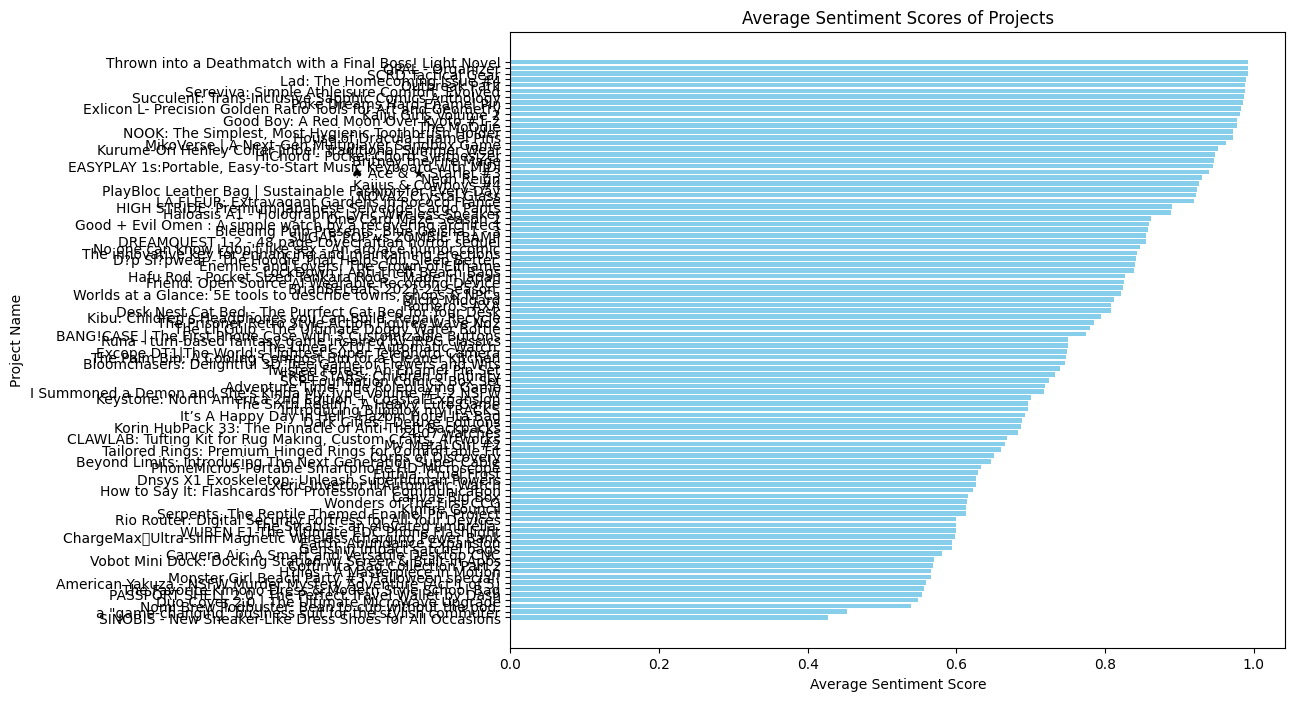

In [17]:


# Sort by average sentiment score
average_sentiment_scores = average_sentiment_scores.sort_values(by='Average Sentiment Score', ascending=False)

# Plot the bar chart
plt.figure(figsize=(10, 8))
plt.barh(average_sentiment_scores['Project Name'], average_sentiment_scores['Average Sentiment Score'], color='skyblue')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Project Name')
plt.title('Average Sentiment Scores of Projects')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest score on top
plt.show()


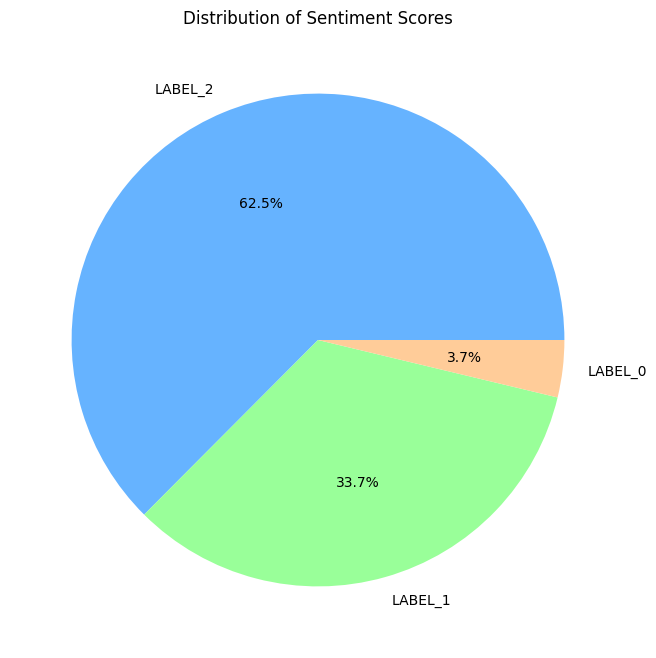

In [18]:
# Assuming sentiment categories and their counts are available
sentiment_counts = sentiment_results_df['Label'].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['#66b3ff','#99ff99','#ffcc99'])
plt.title('Distribution of Sentiment Scores')
plt.show()


In [2]:
import pandas as pd
from transformers import pipeline, RobertaTokenizer
import traceback  # Import traceback for error handling

2024-06-03 06:46:10.207699: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 06:46:10.207817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 06:46:10.324497: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Load the cleaned comments data
comments_cleaned_df = pd.read_excel('/kaggle/input/sorted-comments/comments_cleaned_sorted.xlsx')


# Initialize the sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")
tokenizer = RobertaTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
max_token_length = 512

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [4]:
# Function to split long text into manageable chunks
def split_long_text(text, max_length):
    words = text.split()
    chunks = []
    current_chunk = []
    current_length = 0

    for word in words:
        word_tokens = tokenizer.encode(word, add_special_tokens=False)
        word_length = len(word_tokens)

        if current_length + word_length > max_length:
            if current_chunk:
                chunks.append(" ".join(current_chunk))
            current_chunk = []
            current_length = 0

        current_chunk.append(word)
        current_length += word_length

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return chunks

# Create an empty DataFrame to store sentiment results
sentiment_results_df = pd.DataFrame(columns=["Project", "Category", "Chunk", "Label", "Score"])

# Iterate over each project
project_names = comments_cleaned_df["Project Name"].unique()
project_index = 0

while project_index < len(project_names):
    project_name = project_names[project_index]
    
    try:
        # Filter comments for the current project
        filtered_df = comments_cleaned_df[comments_cleaned_df["Project Name"] == project_name]
        all_comments = " ".join(filtered_df["cleaned comments"].astype(str))  # Ensure all comments are strings

        if not all_comments.strip():
            print(f"No comments for {project_name}. Skipping.")
            project_index += 1
            continue

        # Split long text into manageable chunks
        chunks = split_long_text(all_comments, max_token_length)

        # Analyze sentiment for each chunk
        sentiment_results_list = []

        for chunk_idx, chunk in enumerate(chunks):
            sentiment_result = sentiment_pipeline(chunk)[0]

            # Store sentiment analysis results in the DataFrame
            sentiment_results_list.append({
                "Project": project_name,
                "Category": filtered_df['Category'].iloc[0],  # Assuming category is the same for all comments in a project
                "Chunk": chunk_idx + 1,
                "Label": sentiment_result["label"],
                "Score": sentiment_result["score"]
            })

        # Concatenate the results to the main DataFrame
        sentiment_results_df = pd.concat([sentiment_results_df, pd.DataFrame(sentiment_results_list)], ignore_index=True)

    except Exception as e:
        # If an error occurs, print the error message and continue
        print(f"Error processing {project_name}: {e}")
        traceback.print_exc()

    project_index += 1



/tmp/ipykernel_34/226197620.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sentiment_results_df = pd.concat([sentiment_results_df, pd.DataFrame(sentiment_results_list)], ignore_index=True)


In [5]:
# Now, calculate the average sentiment score for each project including the category
average_sentiment_scores = sentiment_results_df.groupby(['Project', 'Category'])['Score'].mean().reset_index()
average_sentiment_scores.columns = ['Project Name', 'Category', 'Average Sentiment Score']
average_sentiment_scores

,Project Name,Category,Average Sentiment Score
0,24:07 watches,Fashion,0.682428
1,Adventure Time: The Roleplaying Game,Games,0.719709
2,American Yakuza - NSFW Murder Mystery Adventur...,Comics,0.558662
3,BANG!CASE | The First Phone Case with 3 Custom...,Design,0.774436
4,Beyond Limits: Introducing The Next Generation...,Technology,0.646799
...,...,...,...
95,Wonders of The First CCG,Games,0.614663
96,Worlds at a Glance: 5E tools to describe towns...,Games,0.821110
97,Xeric Invertor II Automatic Watch,Design,0.626605
98,"a ""game-changing"" business suit for the stylis...",Fashion,0.453453


In [17]:
average_sentiment_scores.to_csv('average_sentiment_scores.csv', index=False)

In [6]:
# Sort the average sentiment scores in descending order
sorted_average_sentiment_scores = average_sentiment_scores.sort_values(by='Average Sentiment Score', ascending=False)

In [7]:
sorted_average_sentiment_scores

,Project Name,Category,Average Sentiment Score
90,Thrown into a Deathmatch with a Final Boss! Li...,Comics,0.993171
63,OPAL - Organizer,Desgin,0.993159
74,SCRD Tactical Gear,Fashion,0.993159
51,Lad: The Homecoming Issue #4,Comics,0.989829
65,Outbreak Park,Comics,0.988053
...,...,...,...
66,PASSPORT SHELL 2.0 - The Perfect Travel Wallet...,Design,0.554207
21,Duo Cover 2.0 | The Ultimate Microwave Upgrade,Design,0.547871
62,Nomi Brew Podbuster: Bean to cup without the pod.,Technology,0.538625
98,"a ""game-changing"" business suit for the stylis...",Fashion,0.453453


In [ ]:
sorted_average_sentiment_scores.to_csv('sorted_average_sentiment_scores.csv', index=False)

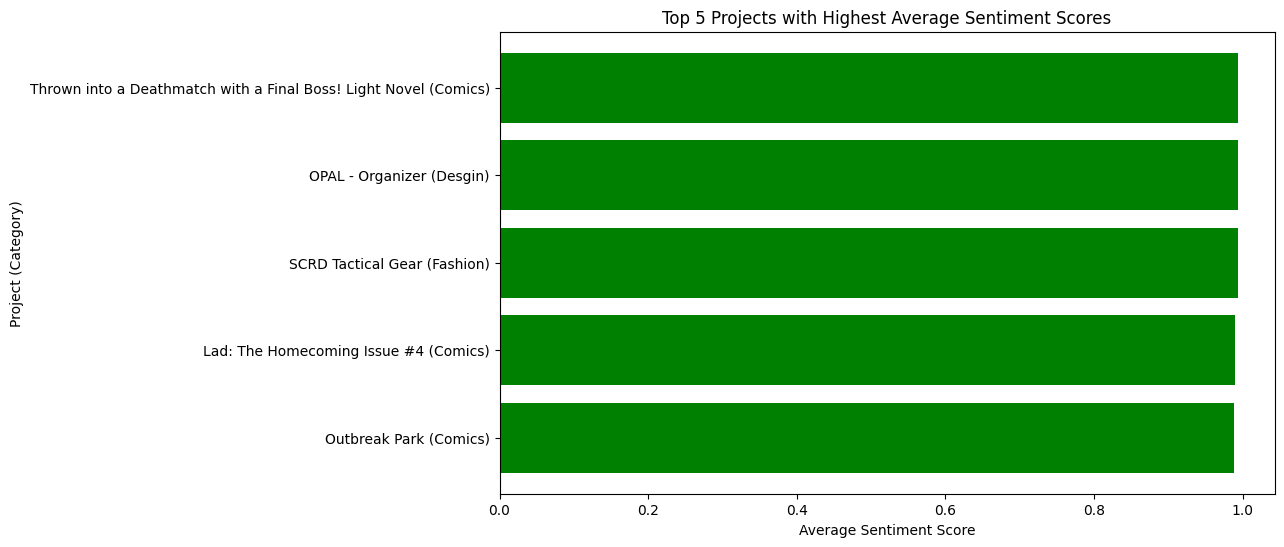

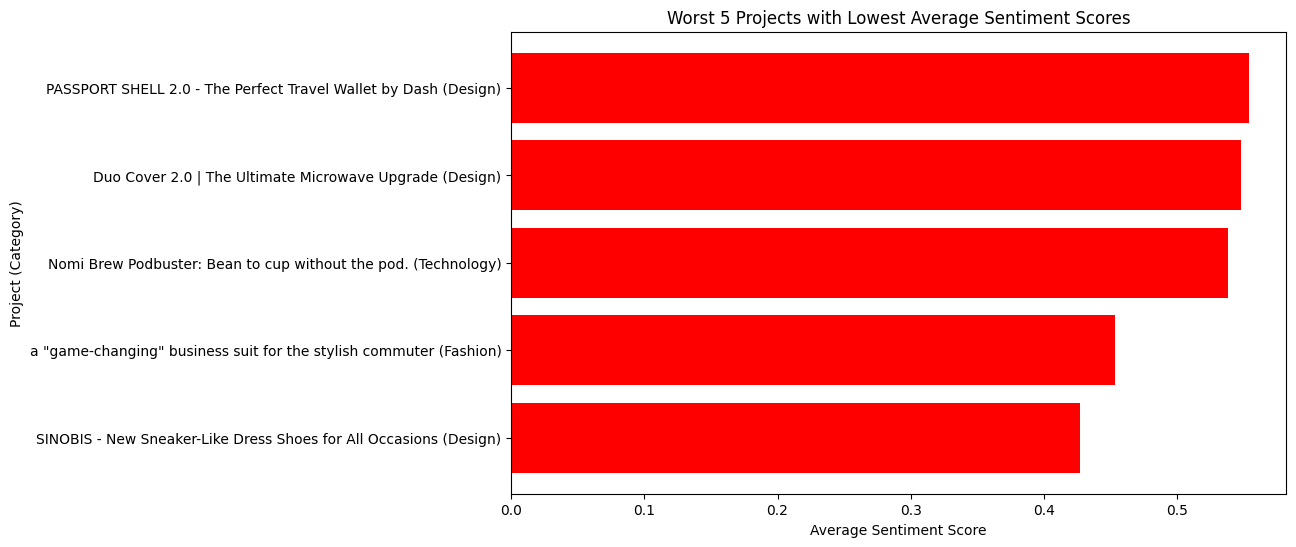

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Get the top 5 and worst 5 projects
top_5_projects = sorted_average_sentiment_scores.head(5)
worst_5_projects = sorted_average_sentiment_scores.tail(5)

# Plot the top 5 projects
plt.figure(figsize=(10, 6))
plt.barh(top_5_projects['Project Name'] + " (" + top_5_projects['Category'] + ")", top_5_projects['Average Sentiment Score'], color='green')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Project (Category)')
plt.title('Top 5 Projects with Highest Average Sentiment Scores')
plt.gca().invert_yaxis()
plt.savefig('top_5_projects.png')
plt.show()

# Plot the worst 5 projects
plt.figure(figsize=(10, 6))
plt.barh(worst_5_projects['Project Name'] + " (" + worst_5_projects['Category'] + ")", worst_5_projects['Average Sentiment Score'], color='red')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Project (Category)')
plt.title('Worst 5 Projects with Lowest Average Sentiment Scores')
plt.gca().invert_yaxis()
plt.savefig('worst_5_projects.png')
plt.show()


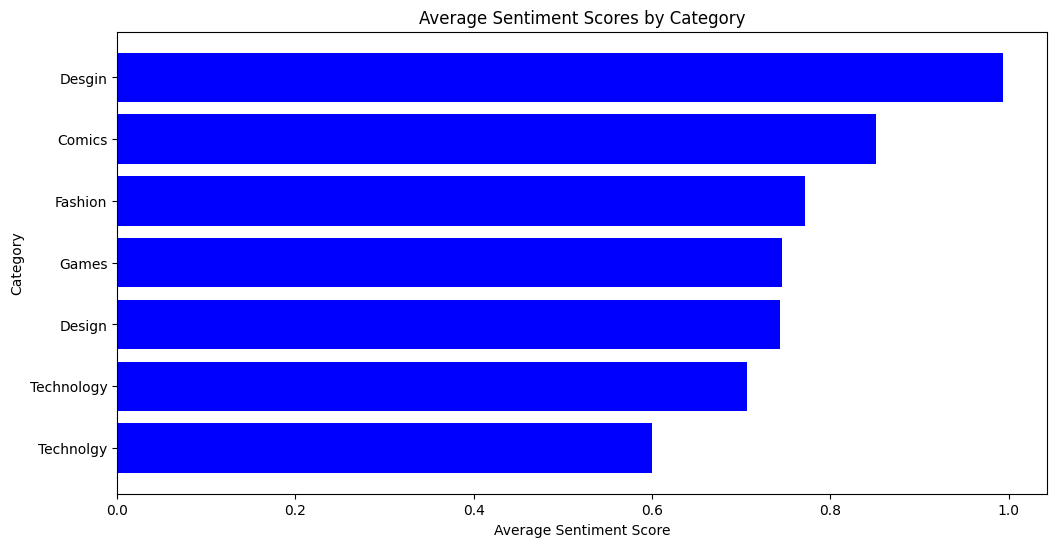

     Category  Average Sentiment Score
1      Desgin                 0.993159
0      Comics                 0.850615
3     Fashion                 0.771678
4       Games                 0.745149
2      Design                 0.743322
6  Technology                 0.705940
5   Technolgy                 0.600248


In [9]:
# Calculate the average sentiment score for each category
average_sentiment_by_category = average_sentiment_scores.groupby('Category')['Average Sentiment Score'].mean().reset_index()
average_sentiment_by_category.columns = ['Category', 'Average Sentiment Score']

# Sort by average sentiment score in descending order
average_sentiment_by_category = average_sentiment_by_category.sort_values(by='Average Sentiment Score', ascending=False)

# Plot the average sentiment scores by category
plt.figure(figsize=(12, 6))
plt.barh(average_sentiment_by_category['Category'], average_sentiment_by_category['Average Sentiment Score'], color='blue')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Category')
plt.title('Average Sentiment Scores by Category')
plt.gca().invert_yaxis()
plt.savefig('average_sentiment_by_category.png')
plt.show()

# Display the average sentiment scores by category
print(average_sentiment_by_category)


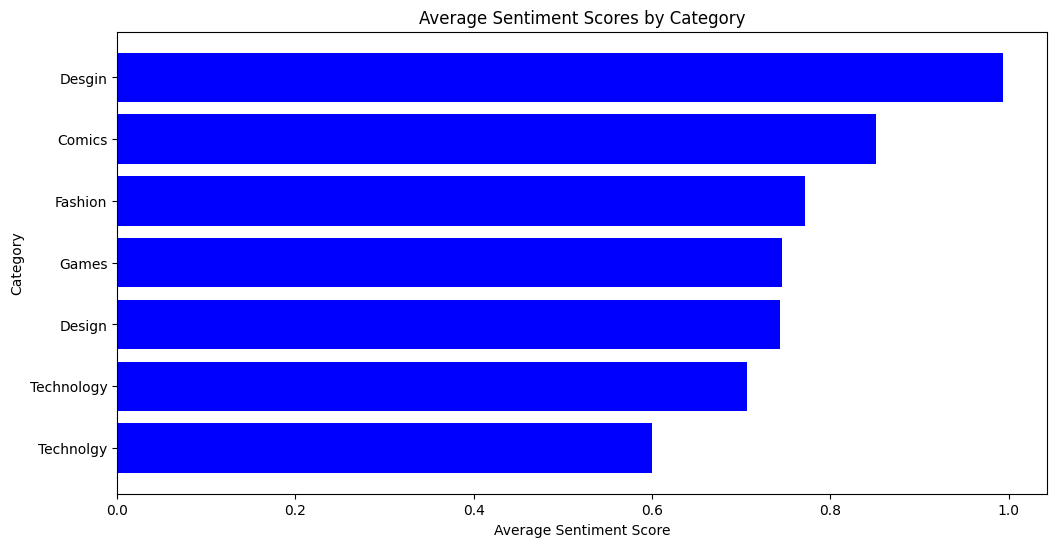

     Category  Average Sentiment Score
1      Desgin                 0.993159
0      Comics                 0.850615
3     Fashion                 0.771678
4       Games                 0.745149
2      Design                 0.743322
6  Technology                 0.705940
5   Technolgy                 0.600248


In [11]:
# Calculate the average sentiment score for each category
average_sentiment_by_category = average_sentiment_scores.groupby('Category')['Average Sentiment Score'].mean().reset_index()
average_sentiment_by_category.columns = ['Category', 'Average Sentiment Score']

# Sort by average sentiment score in descending order
average_sentiment_by_category = average_sentiment_by_category.sort_values(by='Average Sentiment Score', ascending=False)

# Plot the average sentiment scores by category
plt.figure(figsize=(12, 6))
plt.barh(average_sentiment_by_category['Category'], average_sentiment_by_category['Average Sentiment Score'], color='blue')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Category')
plt.title('Average Sentiment Scores by Category')
plt.gca().invert_yaxis()
plt.savefig('average_sentiment_by_category.png')
plt.show()

# Display the average sentiment scores by category
print(average_sentiment_by_category)


In [ ]:
# Export the sorted average sentiment scores to an Excel file
sorted_average_sentiment_scores.to_excel('/mnt/data/sorted_average_sentiment_scores_with_category.xlsx', index=False)

# Display the sorted average sentiment scores
import ace_tools as tools; tools.display_dataframe_to_user(name="Sorted Average Sentiment Scores for All Projects with Category", dataframe=sorted_average_sentiment_scores)

sorted_average_sentiment_scores

In [4]:
import pandas as pd
from transformers import pipeline, RobertaTokenizer

# Load the cleaned comments data
comments_cleaned_df = pd.read_excel('/kaggle/input/sorted-comments/comments_cleaned_sorted.xlsx')

# Initialize the sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")
tokenizer = RobertaTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
max_token_length = 512


In [16]:
import pandas as pd

# Load the provided average sentiment scores CSV file
average_sentiment_scores = pd.read_csv('/kaggle/input/average-sentiment-scores/average_sentiment_scores.csv')


# Load the original comments data to get the list of all projects
comments_cleaned_df = pd.read_excel('/kaggle/input/sorted-comments/comments_cleaned_sorted.xlsx')

# Identify missing projects by comparing the list of projects
missing_projects = set(comments_cleaned_df['Project Name'].unique()) - set(average_sentiment_scores['Project Name'].unique())

# Display the missing projects
missing_projects


{'ChessUp 2 | Chess.com on a Real Board',
 'Lofree EDGE, Smoothest Ultra Low-Profile Mechanical Keyboard',
 'UGREEN NASync Series: Your Private Cloud Storage Solution.'}

In [8]:
# Calculate the average sentiment score for each project
average_sentiment_scores = sentiment_results_df.groupby('Project').apply(
    lambda x: (x['Score'][x['Label'] == 'POSITIVE'].sum() - x['Score'][x['Label'] == 'NEGATIVE'].sum()) / len(x)
).reset_index()
average_sentiment_scores.columns = ['Project Name', 'Average Sentiment Score']

/tmp/ipykernel_34/2716553948.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  average_sentiment_scores = sentiment_results_df.groupby('Project').apply(


In [9]:
# Calculate the average sentiment score for each project

average_sentiment_scores

,Project Name,Average Sentiment Score
0,24:07 watches,0.0
1,Adventure Time: The Roleplaying Game,0.0
2,American Yakuza - NSFW Murder Mystery Adventur...,0.0
3,BANG!CASE | The First Phone Case with 3 Custom...,0.0
4,Beyond Limits: Introducing The Next Generation...,0.0
...,...,...
92,Wonders of The First CCG,0.0
93,Worlds at a Glance: 5E tools to describe towns...,0.0
94,Xeric Invertor II Automatic Watch,0.0
95,"a ""game-changing"" business suit for the stylis...",0.0


In [6]:
# Calculate the average sentiment score for each project
average_scores = sentiment_results_df.groupby("Project")["Score"].mean().reset_index()

# Determine the project with the best overall score
best_project = average_scores.sort_values(by="Score", ascending=False).iloc[0]

print(f"The project with the best overall score is: {best_project['Project']} with an average score of {best_project['Score']}")

The project with the best overall score is: Thrown into a Deathmatch with a Final Boss! Light Novel with an average score of 0.9931706190109253


/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20008 (\N{CJK UNIFIED IDEOGRAPH-4E28}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


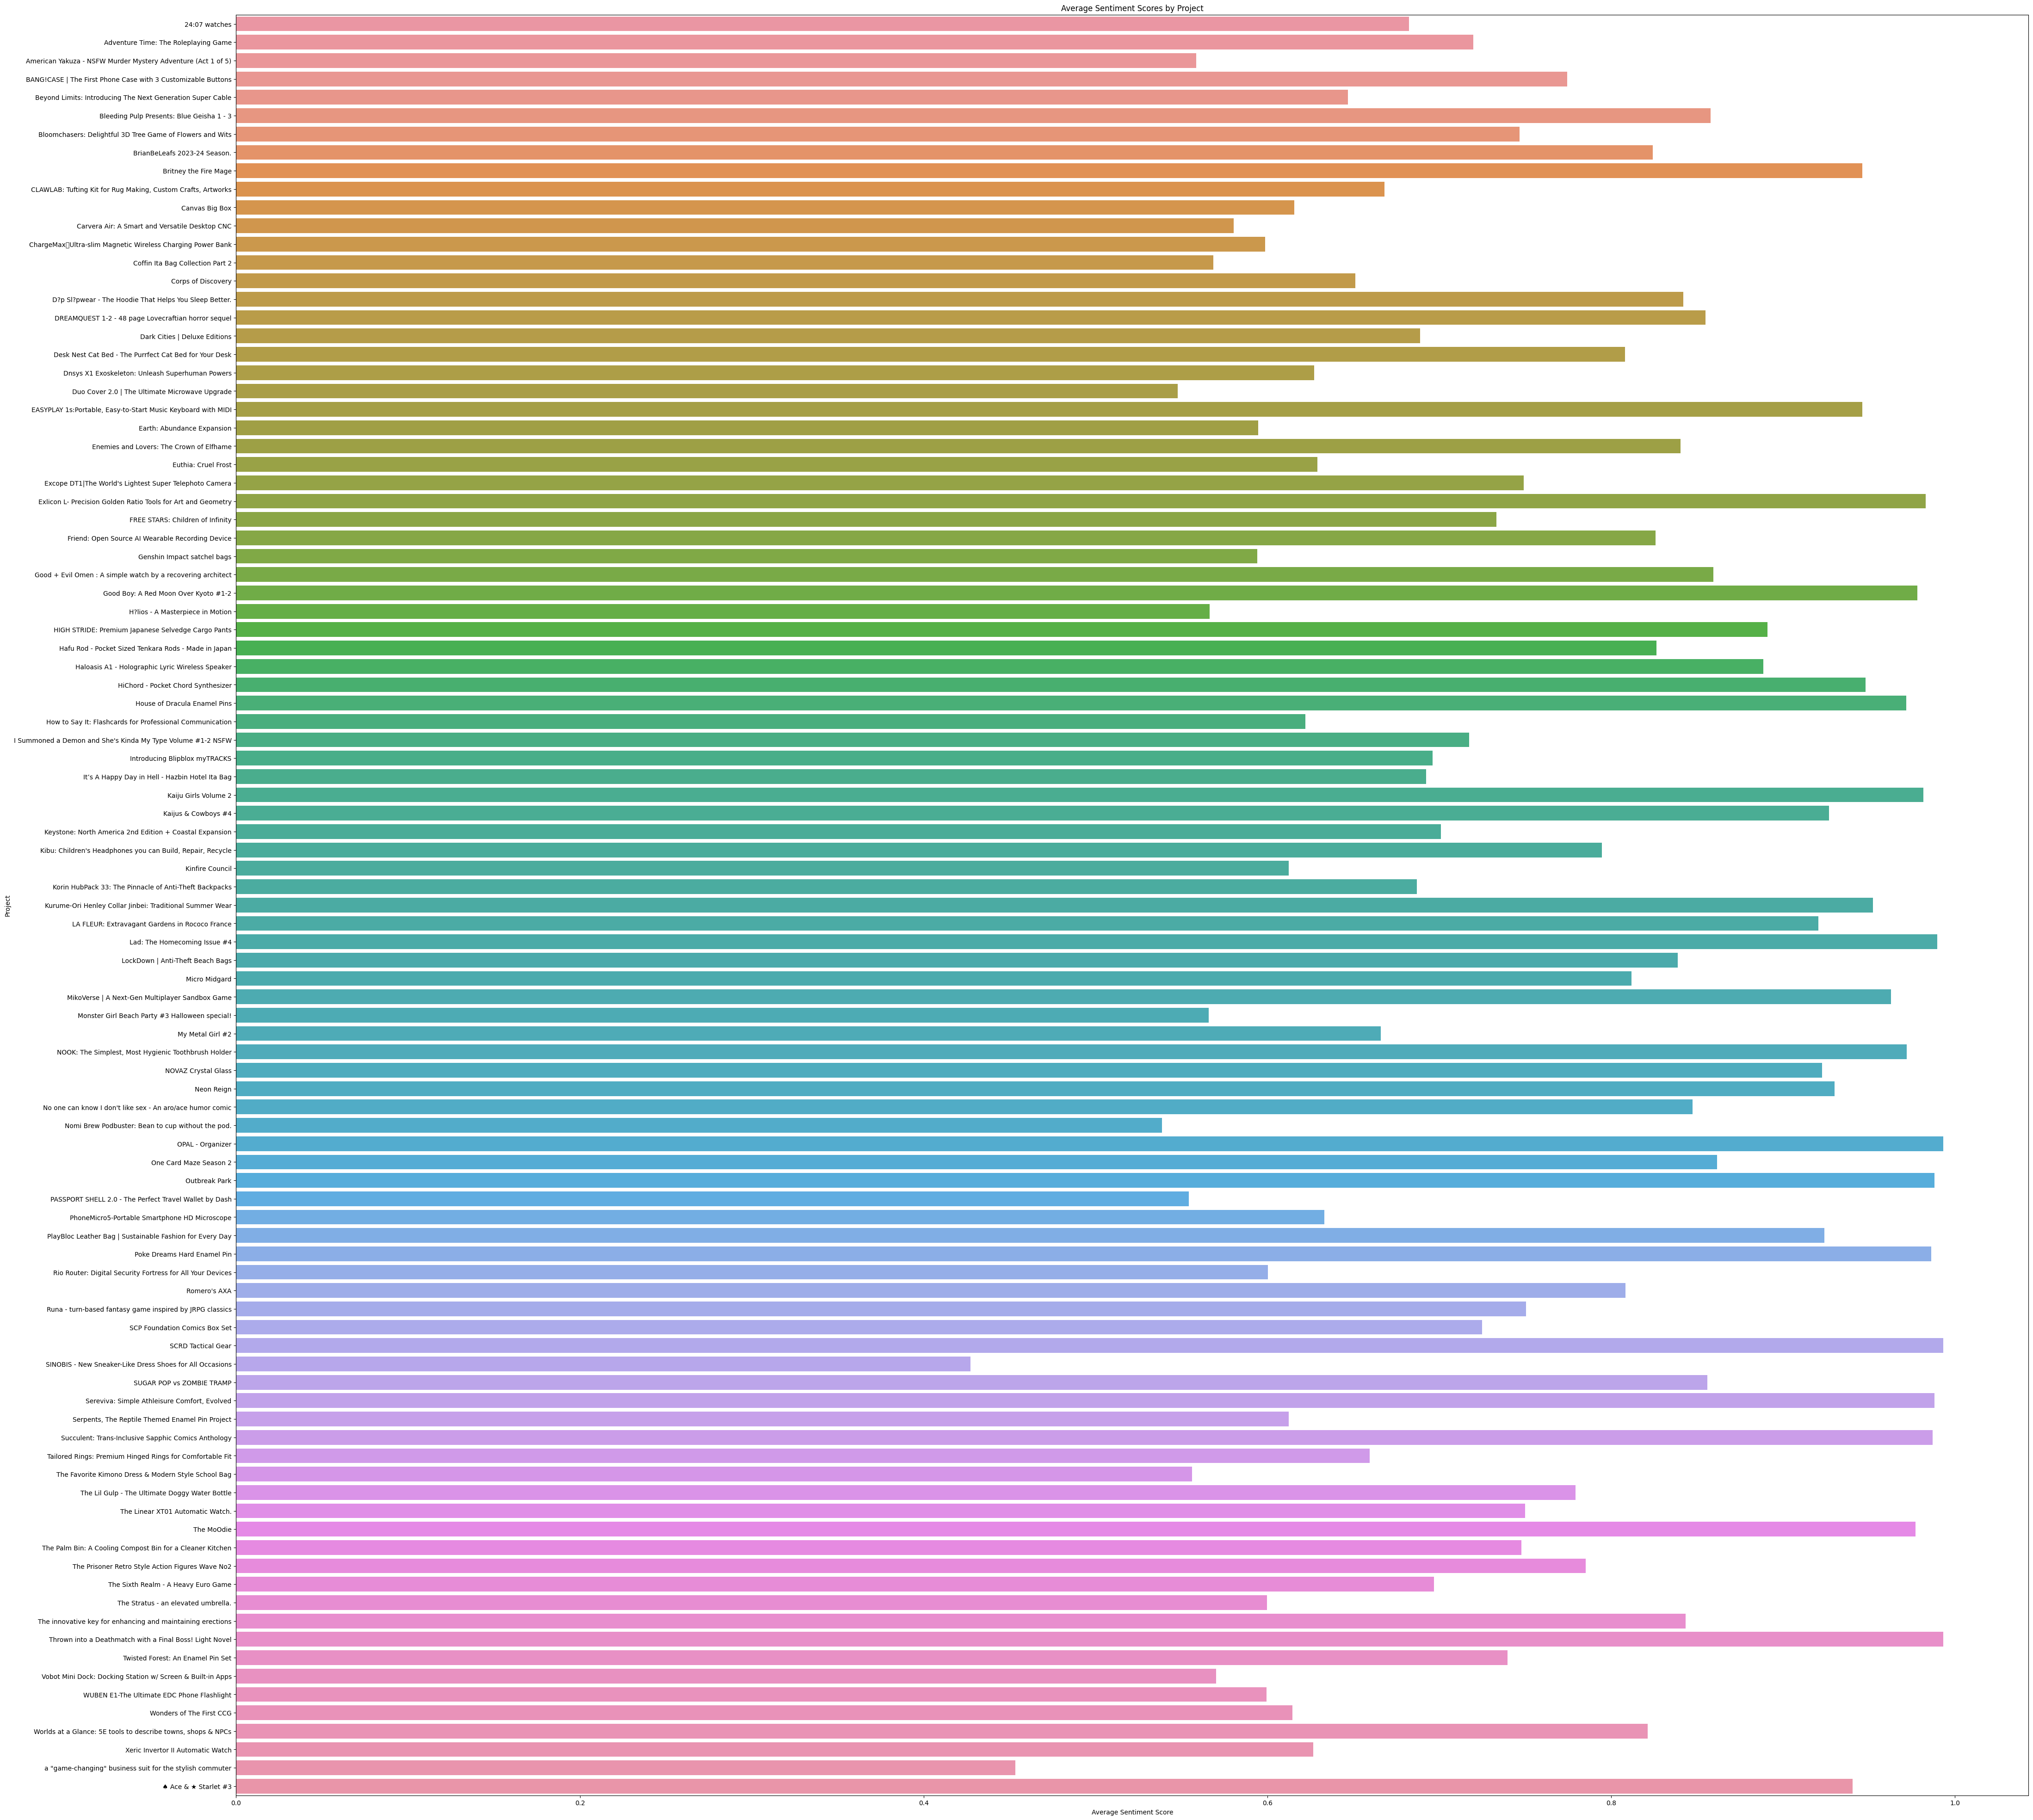

In [10]:
# Visualize the average sentiment scores for each project
plt.figure(figsize=(50, 50))
sns.barplot(data=average_scores, x="Score", y="Project", order=average_scores["Project"].tolist())
plt.title("Average Sentiment Scores by Project")
plt.xlabel("Average Sentiment Score")
plt.ylabel("Project")
plt.show()

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the average sentiment score for each project
average_scores = sentiment_results_df.groupby("Project")["Score"].mean().reset_index()

# Get the top 3 projects with the highest average sentiment scores
top_3_projects = average_scores.sort_values(by="Score", ascending=False).head(3)

print("Top 3 Projects with the Highest Average Sentiment Scores:")
print(top_3_projects)

Top 3 Projects with the Highest Average Sentiment Scores:
                                              Project     Score
88  Thrown into a Deathmatch with a Final Boss! Li...  0.993171
61                                   OPAL - Organizer  0.993159
72                                 SCRD Tactical Gear  0.993159


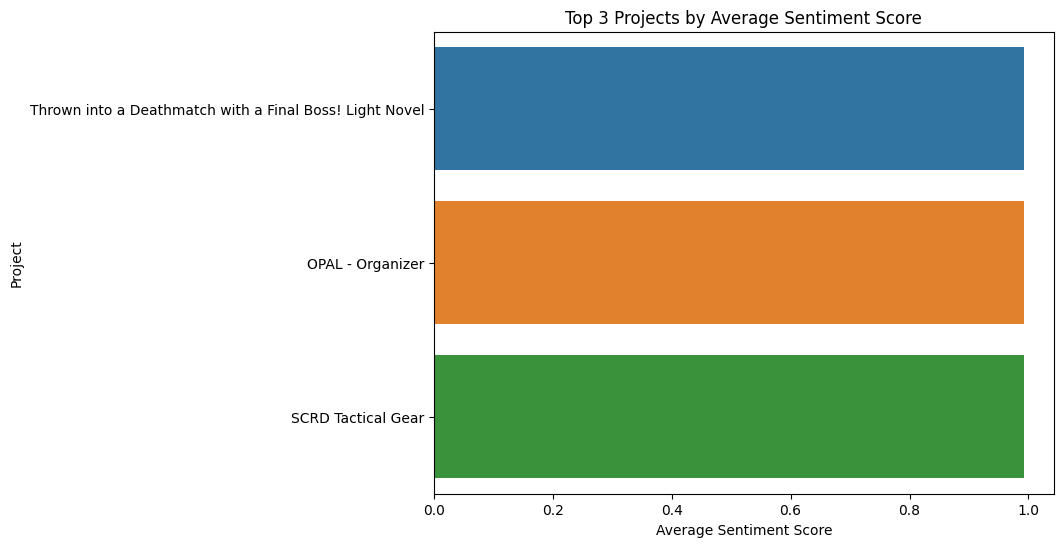

In [16]:
# Visualize the top 3 projects
plt.figure(figsize=(8, 6))
sns.barplot(data=top_3_projects, x="Score", y="Project", order=top_3_projects["Project"].tolist())
plt.title("Top 3 Projects by Average Sentiment Score")
plt.xlabel("Average Sentiment Score")
plt.ylabel("Project")
plt.show()

In [17]:
# Calculate the average sentiment score for each project
average_scores = sentiment_results_df.groupby("Project")["Score"].mean().reset_index()

# Get the worst 3 projects with the highest average sentiment scores
worst_3_projects = average_scores.sort_values(by="Score", ascending=True).head(3)

print("Worst 3 Projects with the Highest Average Sentiment Scores:")
print(worst_3_projects)

Top 3 Projects with the Highest Average Sentiment Scores:
                                              Project     Score
73  SINOBIS - New Sneaker-Like Dress Shoes for All...  0.427378
95  a "game-changing" business suit for the stylis...  0.453453
60  Nomi Brew Podbuster: Bean to cup without the pod.  0.538625


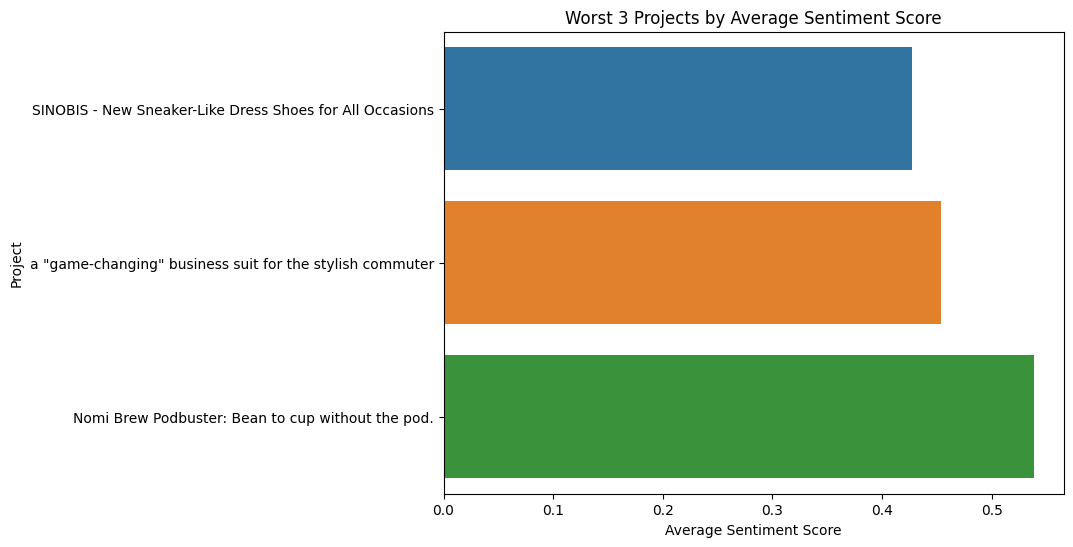

In [18]:
# Visualize the worst 3 projects
plt.figure(figsize=(8, 6))
sns.barplot(data=worst_3_projects, x="Score", y="Project", order=worst_3_projects["Project"].tolist())
plt.title("Worst 3 Projects by Average Sentiment Score")
plt.xlabel("Average Sentiment Score")
plt.ylabel("Project")
plt.show()